In [190]:
import time
from datetime import datetime
from tqdm.keras import TqdmCallback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/Library/Caches/pypoetry/virtualenvs/go-trader-aTWd7ZB6-py3.8/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Read in data

#
- https://blog.rmotr.com/bitcoin-trading-with-python-bollinger-bands-strategy-analysis-b1a223385a89

In [2]:
data = pd.read_csv("../data/localbtcUSD.csv", names=["datetime", "price", "volume"],
    index_col=0,
    parse_dates=True)

In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3977580 entries, 1363046255 to 1546938874
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   volume  float64
dtypes: float64(2)
memory usage: 91.0 MB


In [4]:
data.index = pd.to_datetime(data.index, unit='s')

In [5]:
data.head()

,price,volume
datetime,,
2013-03-11 23:57:35,72.00,4.9999
2013-03-12 19:36:32,67.79,1.9999
2013-03-13 12:27:52,52.21,14.7684
2013-03-13 17:06:01,56.29,0.6401
2013-03-13 18:01:20,40.00,1.7500


In [6]:
data.tail()

,price,volume
datetime,,
2019-01-08 09:11:30,4057.75,0.024644
2019-01-08 09:12:14,6002.25,0.031655
2019-01-08 09:13:12,4293.61,0.132988
2019-01-08 09:13:44,4517.69,0.006641
2019-01-08 09:14:34,4170.85,0.235444


In [7]:
price_df = data.price.resample("D").ohlc()

### Candles

In [8]:
price_df.head()

,open,high,low,close
datetime,,,,
2013-03-11,72.00,72.00,72.00,72.00
2013-03-12,67.79,67.79,67.79,67.79
2013-03-13,52.21,56.29,40.00,40.00
2013-03-14,70.30,70.30,50.35,50.35
2013-03-15,49.52,70.96,47.75,48.41


## Calculate Bollinger Bands

In [110]:
# set number of days and standard deviations to use for rolling 
# lookback period for Bollinger band calculation
window = 60
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = price_df['close'].rolling(window).mean()
rolling_std = price_df['close'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
price_df['Rolling Mean'] = rolling_mean
price_df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
price_df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

In [111]:
price_df.dropna(inplace=True)

In [115]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2014-12-12,350.40,5000.00,314.75,336.24,514.854833,643.516573,386.193094,1.0,-0.084314,-0.084314
2014-12-13,386.98,5000.00,307.81,398.94,512.364500,642.783982,381.945018,1.0,0.186474,0.186474
2014-12-14,349.82,10000.00,314.91,411.81,510.525000,642.371204,378.678796,1.0,0.032260,0.032260
2014-12-15,412.67,867.05,228.80,361.25,508.442167,643.352298,373.532036,1.0,-0.122775,-0.122775
2014-12-16,335.07,1200.48,217.94,396.01,506.604667,643.260834,369.948500,1.0,0.096221,0.096221
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571,1.0,0.072237,0.072237


In [112]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1489 entries, 2014-12-12 to 2019-01-08
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             1489 non-null   float64
 1   high             1489 non-null   float64
 2   low              1489 non-null   float64
 3   close            1489 non-null   float64
 4   Rolling Mean     1489 non-null   float64
 5   Bollinger High   1489 non-null   float64
 6   Bollinger Low    1489 non-null   float64
 7   Position         1489 non-null   float64
 8   Market Return    1489 non-null   float64
 9   Strategy Return  1489 non-null   float64
dtypes: float64(10)
memory usage: 128.0 KB


<AxesSubplot:xlabel='datetime'>

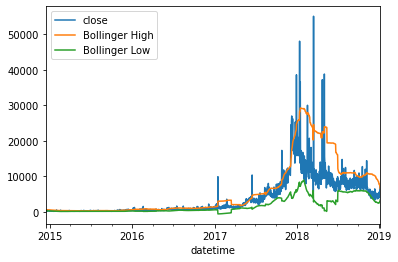

In [113]:
price_df[['close','Bollinger High','Bollinger Low']].plot()


In [135]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2014-12-12,350.40,5000.00,314.75,336.24,514.854833,643.516573,386.193094,1.0,-0.084314,-0.084314
2014-12-13,386.98,5000.00,307.81,398.94,512.364500,642.783982,381.945018,1.0,0.186474,0.186474
2014-12-14,349.82,10000.00,314.91,411.81,510.525000,642.371204,378.678796,1.0,0.032260,0.032260
2014-12-15,412.67,867.05,228.80,361.25,508.442167,643.352298,373.532036,1.0,-0.122775,-0.122775
2014-12-16,335.07,1200.48,217.94,396.01,506.604667,643.260834,369.948500,1.0,0.096221,0.096221
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,5215.888833,7754.694356,2677.083311,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,5138.482667,7473.680047,2803.285286,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,5135.433000,7467.581429,2803.284571,1.0,0.072237,0.072237


<AxesSubplot:xlabel='datetime'>

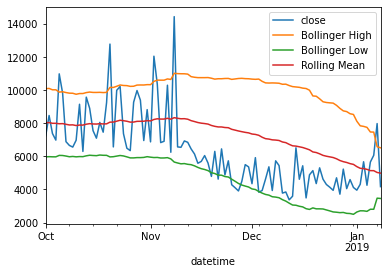

In [133]:
price_df[price_df.index >= '2018-10-01'][['close','Bollinger High','Bollinger Low', 'Rolling Mean']].plot()


### Train LSTM

In [209]:
COLS = ['open',	'high',	'low',	'close',	'Rolling Mean',	'Bollinger High',	'Bollinger Low']
dataset_train = price_df[:int(price_df.shape[0]*0.8) ][COLS] 
dataset_test = price_df[int(price_df.shape[0]*0.8):][COLS]

In [210]:
dataset_train.shape

(1191, 7)

In [218]:
def create_dataset(df, n_days=7):
    X_COLS = ['open',	'high',	'low',		'Rolling Mean',	'Bollinger High',	'Bollinger Low']
    Y_COL = ['close']
    x = []
    y = []
    for i in range(n_days, df.shape[0]):
        x.append(df.loc[i-n_days:i, X_COLS])
        y.append(df.loc[i, Y_COL])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [236]:
dataset_train.reset_index(drop=True).loc[10:15,  ['open',	'high',	'low',		'Rolling Mean',	'Bollinger High',	'Bollinger Low']]

,open,high,low,Rolling Mean,Bollinger High,Bollinger Low
10,341.69,3333.33,289.38,496.520833,647.612178,345.429489
11,396.04,2990.43,285.71,490.880167,637.437637,344.322696
12,404.14,700.00,283.53,489.098500,636.396776,341.800224
13,637.76,798.72,264.31,486.406000,635.746144,337.065856
14,379.61,1300.39,291.11,482.787500,633.385399,332.189601
15,950.12,1264.22,206.06,479.745333,630.112937,329.377729


In [227]:
x_train, y_train = create_dataset(dataset_train.reset_index(drop=True))

In [229]:
x_train.shape

(1184, 8, 6)

In [231]:
x_test.shape

(291, 8, 6)

In [230]:
x_test, y_test = create_dataset(dataset_test.reset_index(drop=True))

In [221]:
y_train

array([  404.75,   444.71,   395.88, ..., 13773.93, 10375.41, 12817.88])

In [162]:

scaler = MinMaxScaler(feature_range=(0,1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [163]:
# reshape for lstm
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [194]:
def buid_lstm():
    model = Sequential()
    model.add(LSTM(units=96, return_sequences=True))
    model.add(Dropout(0.02))
    model.add(LSTM(units=96,return_sequences=True))
    model.add(Dropout(0.020))
    model.add(LSTM(units=96,return_sequences=True))
    model.add(Dropout(0.02))
    model.add(LSTM(units=96))
    model.add(Dropout(0.0200))
    model.add(Dense(units=1))
    return model

In [195]:
model = buid_lstm()

In [196]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [198]:
x_train.shape

(1184, 7, 1)

In [199]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [204]:
history = model.fit(x_train, y_train, epochs=500, batch_size=128, callbacks=[TqdmCallback(verbose=0)])

Epoch 1/500
10/10 [==============================] - 0s 35ms/step - loss: 31899246.0000


Epoch 2/500
10/10 [==============================] - 0s 38ms/step - loss: 31894390.0000


Epoch 3/500
10/10 [==============================] - 0s 32ms/step - loss: 31889616.0000


Epoch 4/500
10/10 [==============================] - 0s 34ms/step - loss: 31884204.0000


Epoch 5/500
10/10 [==============================] - 0s 32ms/step - loss: 31879766.0000


Epoch 6/500
10/10 [==============================] - 0s 31ms/step - loss: 31874466.0000


Epoch 7/500
10/10 [==============================] - 0s 32ms/step - loss: 31870090.0000


Epoch 8/500
10/10 [==============================] - 0s 39ms/step - loss: 31864268.0000


Epoch 9/500
10/10 [==============================] - 0s 45ms/step - loss: 31859916.0000


Epoch 10/500
10/10 [==============================] - 0s 33ms/step - loss: 31854880.0000


Epoch 11/500
10/10 [==============================] - 0s 31ms/step - loss: 31850292.0000


Epoch 12/500
10/10 [==============================] - 0s 30ms/step - loss: 31844950.0000


Epoch 13/500
10/10 [==============================] - 0s 31ms/step - loss: 31839872.0000


Epoch 14/500
10/10 [==============================] - 0s 32ms/step - loss: 31836174.0000


Epoch 15/500
10/10 [==============================] - 0s 31ms/step - loss: 31830020.0000


Epoch 16/500
10/10 [==============================] - 0s 30ms/step - loss: 31826132.0000


Epoch 17/500
10/10 [==============================] - 0s 32ms/step - loss: 31820218.0000


Epoch 18/500
10/10 [==============================] - 0s 34ms/step - loss: 31815902.0000


Epoch 19/500
10/10 [==============================] - 0s 32ms/step - loss: 31810348.0000


Epoch 20/500
10/10 [==============================] - 0s 31ms/step - loss: 31805768.0000


Epoch 21/500
10/10 [==============================] - 0s 33ms/step - loss: 31800130.0000


Epoch 22/500
10/10 [==============================] - 0s 32ms/step - loss: 31795504.0000


Epoch 23/500
10/10 [==============================] - 0s 32ms/step - loss: 31791000.0000


Epoch 24/500
10/10 [==============================] - 0s 31ms/step - loss: 31785850.0000


Epoch 25/500
10/10 [==============================] - 0s 31ms/step - loss: 31781546.0000


Epoch 26/500
10/10 [==============================] - 0s 33ms/step - loss: 31775764.0000


Epoch 27/500
10/10 [==============================] - 0s 32ms/step - loss: 31772534.0000


Epoch 28/500
10/10 [==============================] - 0s 32ms/step - loss: 31765794.0000


Epoch 29/500
10/10 [==============================] - 0s 31ms/step - loss: 31761402.0000


Epoch 30/500
10/10 [==============================] - 0s 32ms/step - loss: 31756744.0000


Epoch 31/500
10/10 [==============================] - 0s 32ms/step - loss: 31751660.0000


Epoch 32/500
10/10 [==============================] - 0s 32ms/step - loss: 31747896.0000


Epoch 33/500
10/10 [==============================] - 0s 31ms/step - loss: 31742924.0000


Epoch 34/500
10/10 [==============================] - 0s 33ms/step - loss: 31737596.0000


Epoch 35/500
10/10 [==============================] - 0s 31ms/step - loss: 31733138.0000


Epoch 36/500
10/10 [==============================] - 0s 31ms/step - loss: 31727660.0000


Epoch 37/500
10/10 [==============================] - 0s 38ms/step - loss: 31722766.0000


Epoch 38/500
10/10 [==============================] - 0s 34ms/step - loss: 31717902.0000


Epoch 39/500
10/10 [==============================] - 0s 35ms/step - loss: 31713592.0000


Epoch 40/500
10/10 [==============================] - 0s 44ms/step - loss: 31706326.0000


Epoch 41/500
10/10 [==============================] - 0s 43ms/step - loss: 31702504.0000


Epoch 42/500
10/10 [==============================] - 0s 36ms/step - loss: 31698736.0000


Epoch 43/500
10/10 [==============================] - 0s 34ms/step - loss: 31693074.0000


Epoch 44/500
10/10 [==============================] - 0s 36ms/step - loss: 31687594.0000


Epoch 45/500
10/10 [==============================] - 0s 34ms/step - loss: 31683266.0000


Epoch 46/500
10/10 [==============================] - 0s 47ms/step - loss: 31678236.0000


Epoch 47/500
10/10 [==============================] - 0s 38ms/step - loss: 31672514.0000


Epoch 48/500
10/10 [==============================] - 0s 36ms/step - loss: 31668286.0000


Epoch 49/500
10/10 [==============================] - 0s 34ms/step - loss: 31662596.0000


Epoch 50/500
10/10 [==============================] - 0s 33ms/step - loss: 31657116.0000


Epoch 51/500
10/10 [==============================] - 0s 33ms/step - loss: 31652626.0000


Epoch 52/500
10/10 [==============================] - 0s 38ms/step - loss: 31647606.0000


Epoch 53/500
10/10 [==============================] - 0s 34ms/step - loss: 31643430.0000


Epoch 54/500
10/10 [==============================] - 0s 35ms/step - loss: 31638134.0000


Epoch 55/500
10/10 [==============================] - 0s 34ms/step - loss: 31634204.0000


Epoch 56/500
10/10 [==============================] - 0s 33ms/step - loss: 31628692.0000


Epoch 57/500
10/10 [==============================] - 0s 34ms/step - loss: 31624160.0000


Epoch 58/500
10/10 [==============================] - 0s 32ms/step - loss: 31619770.0000


Epoch 59/500
10/10 [==============================] - 0s 33ms/step - loss: 31615146.0000


Epoch 60/500
10/10 [==============================] - 0s 35ms/step - loss: 31608040.0000


Epoch 61/500
10/10 [==============================] - 0s 33ms/step - loss: 31603618.0000


Epoch 62/500
10/10 [==============================] - 0s 34ms/step - loss: 31599712.0000


Epoch 63/500
10/10 [==============================] - 0s 33ms/step - loss: 31594890.0000


Epoch 64/500
10/10 [==============================] - 0s 34ms/step - loss: 31590168.0000


Epoch 65/500
10/10 [==============================] - 0s 33ms/step - loss: 31584138.0000


Epoch 66/500
10/10 [==============================] - 0s 35ms/step - loss: 31579884.0000


Epoch 67/500
10/10 [==============================] - 0s 41ms/step - loss: 31575674.0000


Epoch 68/500
10/10 [==============================] - 0s 32ms/step - loss: 31570546.0000


Epoch 69/500
10/10 [==============================] - 0s 33ms/step - loss: 31564028.0000


Epoch 70/500
10/10 [==============================] - 0s 34ms/step - loss: 31560006.0000


Epoch 71/500
10/10 [==============================] - 0s 33ms/step - loss: 31555774.0000


Epoch 72/500
10/10 [==============================] - 0s 33ms/step - loss: 31550702.0000


Epoch 73/500
10/10 [==============================] - 0s 33ms/step - loss: 31545800.0000


Epoch 74/500
10/10 [==============================] - 0s 34ms/step - loss: 31540960.0000


Epoch 75/500
10/10 [==============================] - 0s 34ms/step - loss: 31536584.0000


Epoch 76/500
10/10 [==============================] - 0s 33ms/step - loss: 31530766.0000


Epoch 77/500
10/10 [==============================] - 0s 34ms/step - loss: 31527150.0000


Epoch 78/500
10/10 [==============================] - 0s 34ms/step - loss: 31521390.0000


Epoch 79/500
10/10 [==============================] - 0s 34ms/step - loss: 31516396.0000


Epoch 80/500
10/10 [==============================] - 0s 34ms/step - loss: 31513486.0000


Epoch 81/500
10/10 [==============================] - 0s 35ms/step - loss: 31507532.0000


Epoch 82/500
10/10 [==============================] - 0s 34ms/step - loss: 31501858.0000


Epoch 83/500
10/10 [==============================] - 0s 33ms/step - loss: 31497918.0000


Epoch 84/500
10/10 [==============================] - 0s 33ms/step - loss: 31493424.0000


Epoch 85/500
10/10 [==============================] - 0s 33ms/step - loss: 31487536.0000


Epoch 86/500
10/10 [==============================] - 0s 32ms/step - loss: 31483156.0000


Epoch 87/500
10/10 [==============================] - 0s 32ms/step - loss: 31478504.0000


Epoch 88/500
10/10 [==============================] - 0s 33ms/step - loss: 31472464.0000


Epoch 89/500
10/10 [==============================] - 0s 34ms/step - loss: 31468938.0000


Epoch 90/500
10/10 [==============================] - 0s 34ms/step - loss: 31463942.0000


Epoch 91/500
10/10 [==============================] - 0s 33ms/step - loss: 31459954.0000


Epoch 92/500
10/10 [==============================] - 0s 34ms/step - loss: 31454084.0000


Epoch 93/500
10/10 [==============================] - 0s 35ms/step - loss: 31448594.0000


Epoch 94/500
10/10 [==============================] - 0s 37ms/step - loss: 31442096.0000


Epoch 95/500
10/10 [==============================] - 0s 34ms/step - loss: 31438692.0000


Epoch 96/500
10/10 [==============================] - 0s 35ms/step - loss: 31433870.0000


Epoch 97/500
10/10 [==============================] - 0s 35ms/step - loss: 31427670.0000


Epoch 98/500
10/10 [==============================] - 0s 34ms/step - loss: 31425270.0000


Epoch 99/500
10/10 [==============================] - 0s 35ms/step - loss: 31420676.0000


Epoch 100/500
10/10 [==============================] - 0s 34ms/step - loss: 31415252.0000


Epoch 101/500
10/10 [==============================] - 0s 45ms/step - loss: 31410532.0000


Epoch 102/500
10/10 [==============================] - 0s 35ms/step - loss: 31404820.0000


Epoch 103/500
10/10 [==============================] - 0s 34ms/step - loss: 31399282.0000


Epoch 104/500
10/10 [==============================] - 0s 35ms/step - loss: 31395940.0000


Epoch 105/500
10/10 [==============================] - 0s 34ms/step - loss: 31389596.0000


Epoch 106/500
10/10 [==============================] - 0s 35ms/step - loss: 31385312.0000


Epoch 107/500
10/10 [==============================] - 0s 34ms/step - loss: 31379560.0000


Epoch 108/500
10/10 [==============================] - 0s 33ms/step - loss: 31375572.0000


Epoch 109/500
10/10 [==============================] - 0s 40ms/step - loss: 31369150.0000


Epoch 110/500
10/10 [==============================] - 0s 33ms/step - loss: 31365556.0000


Epoch 111/500
10/10 [==============================] - 0s 35ms/step - loss: 31360104.0000


Epoch 112/500
10/10 [==============================] - 0s 34ms/step - loss: 31357678.0000


Epoch 113/500
10/10 [==============================] - 0s 37ms/step - loss: 31351424.0000


Epoch 114/500
10/10 [==============================] - 0s 36ms/step - loss: 31345114.0000


Epoch 115/500
10/10 [==============================] - 0s 35ms/step - loss: 31340748.0000


Epoch 116/500
10/10 [==============================] - 0s 34ms/step - loss: 31337340.0000


Epoch 117/500
10/10 [==============================] - 0s 34ms/step - loss: 31332884.0000


Epoch 118/500
10/10 [==============================] - 0s 37ms/step - loss: 31327754.0000


Epoch 119/500
10/10 [==============================] - 0s 35ms/step - loss: 31324434.0000


Epoch 120/500
10/10 [==============================] - 0s 35ms/step - loss: 31317510.0000


Epoch 121/500
10/10 [==============================] - 0s 33ms/step - loss: 31311754.0000


Epoch 122/500
10/10 [==============================] - 0s 35ms/step - loss: 31310398.0000


Epoch 123/500
10/10 [==============================] - 0s 34ms/step - loss: 31303334.0000


Epoch 124/500
10/10 [==============================] - 0s 35ms/step - loss: 31299244.0000


Epoch 125/500
10/10 [==============================] - 1s 51ms/step - loss: 31292790.0000


Epoch 126/500
10/10 [==============================] - 0s 37ms/step - loss: 31288136.0000


Epoch 127/500
10/10 [==============================] - 0s 35ms/step - loss: 31283462.0000


Epoch 128/500
10/10 [==============================] - 0s 35ms/step - loss: 31278664.0000


Epoch 129/500
10/10 [==============================] - 0s 34ms/step - loss: 31274590.0000


Epoch 130/500
10/10 [==============================] - 0s 35ms/step - loss: 31268536.0000


Epoch 131/500
10/10 [==============================] - 0s 33ms/step - loss: 31264446.0000


Epoch 132/500
10/10 [==============================] - 0s 35ms/step - loss: 31260344.0000


Epoch 133/500
10/10 [==============================] - 1s 53ms/step - loss: 31255514.0000


Epoch 134/500
10/10 [==============================] - 1s 50ms/step - loss: 31250066.0000


Epoch 135/500
10/10 [==============================] - 1s 59ms/step - loss: 31247304.0000


Epoch 136/500
10/10 [==============================] - 0s 35ms/step - loss: 31240410.0000


Epoch 137/500
10/10 [==============================] - 0s 36ms/step - loss: 31237228.0000


Epoch 138/500
10/10 [==============================] - 0s 31ms/step - loss: 31231270.0000


Epoch 139/500
10/10 [==============================] - 0s 31ms/step - loss: 31226132.0000


Epoch 140/500
10/10 [==============================] - 0s 31ms/step - loss: 31220328.0000


Epoch 141/500
10/10 [==============================] - 0s 30ms/step - loss: 31215284.0000


Epoch 142/500
10/10 [==============================] - 0s 30ms/step - loss: 31212810.0000


Epoch 143/500
10/10 [==============================] - 0s 30ms/step - loss: 31207456.0000


Epoch 144/500
10/10 [==============================] - 0s 29ms/step - loss: 31199906.0000


Epoch 145/500
10/10 [==============================] - 0s 29ms/step - loss: 31196578.0000


Epoch 146/500
10/10 [==============================] - 0s 30ms/step - loss: 31192160.0000


Epoch 147/500
10/10 [==============================] - 0s 29ms/step - loss: 31186678.0000


Epoch 148/500
10/10 [==============================] - 0s 29ms/step - loss: 31183956.0000


Epoch 149/500
10/10 [==============================] - 0s 29ms/step - loss: 31178054.0000


Epoch 150/500
10/10 [==============================] - 0s 45ms/step - loss: 31174946.0000


Epoch 151/500
10/10 [==============================] - 0s 30ms/step - loss: 31168052.0000


Epoch 152/500
10/10 [==============================] - 0s 29ms/step - loss: 31163322.0000


Epoch 153/500
10/10 [==============================] - 0s 29ms/step - loss: 31158410.0000


Epoch 154/500
10/10 [==============================] - 0s 29ms/step - loss: 31153902.0000


Epoch 155/500
10/10 [==============================] - 0s 30ms/step - loss: 31148426.0000


Epoch 156/500
10/10 [==============================] - 0s 30ms/step - loss: 31144714.0000


Epoch 157/500
10/10 [==============================] - 0s 31ms/step - loss: 31139540.0000


Epoch 158/500
10/10 [==============================] - 0s 31ms/step - loss: 31135326.0000


Epoch 159/500
10/10 [==============================] - 0s 31ms/step - loss: 31129784.0000


Epoch 160/500
10/10 [==============================] - 0s 34ms/step - loss: 31128292.0000


Epoch 161/500
10/10 [==============================] - 0s 34ms/step - loss: 31119640.0000


Epoch 162/500
10/10 [==============================] - 0s 32ms/step - loss: 31116232.0000


Epoch 163/500
10/10 [==============================] - 0s 32ms/step - loss: 31111480.0000


Epoch 164/500
10/10 [==============================] - 0s 32ms/step - loss: 31105744.0000


Epoch 165/500
10/10 [==============================] - 0s 41ms/step - loss: 31101820.0000


Epoch 166/500
10/10 [==============================] - 0s 33ms/step - loss: 31097396.0000


Epoch 167/500
10/10 [==============================] - 0s 31ms/step - loss: 31092798.0000


Epoch 168/500
10/10 [==============================] - 0s 31ms/step - loss: 31086904.0000


Epoch 169/500
10/10 [==============================] - 0s 32ms/step - loss: 31082094.0000


Epoch 170/500
10/10 [==============================] - 0s 30ms/step - loss: 31079084.0000


Epoch 171/500
10/10 [==============================] - 0s 31ms/step - loss: 31073156.0000


Epoch 172/500
10/10 [==============================] - 0s 31ms/step - loss: 31068714.0000


Epoch 173/500
10/10 [==============================] - 0s 30ms/step - loss: 31062532.0000


Epoch 174/500
10/10 [==============================] - 0s 30ms/step - loss: 31059518.0000


Epoch 175/500
10/10 [==============================] - 0s 30ms/step - loss: 31054724.0000


Epoch 176/500
10/10 [==============================] - 0s 30ms/step - loss: 31047956.0000


Epoch 177/500
10/10 [==============================] - 0s 30ms/step - loss: 31046614.0000


Epoch 178/500
10/10 [==============================] - 0s 30ms/step - loss: 31039430.0000


Epoch 179/500
10/10 [==============================] - 0s 29ms/step - loss: 31037204.0000


Epoch 180/500
10/10 [==============================] - 0s 29ms/step - loss: 31031278.0000


Epoch 181/500
10/10 [==============================] - 0s 29ms/step - loss: 31027730.0000


Epoch 182/500
10/10 [==============================] - 0s 31ms/step - loss: 31021140.0000


Epoch 183/500
10/10 [==============================] - 0s 32ms/step - loss: 31016120.0000


Epoch 184/500
10/10 [==============================] - 0s 31ms/step - loss: 31011536.0000


Epoch 185/500
10/10 [==============================] - 0s 31ms/step - loss: 31008838.0000


Epoch 186/500
10/10 [==============================] - 0s 35ms/step - loss: 31002572.0000


Epoch 187/500
10/10 [==============================] - 0s 35ms/step - loss: 30996324.0000


Epoch 188/500
10/10 [==============================] - 0s 32ms/step - loss: 30993020.0000


Epoch 189/500
10/10 [==============================] - 0s 31ms/step - loss: 30990252.0000


Epoch 190/500
10/10 [==============================] - 0s 33ms/step - loss: 30983362.0000


Epoch 191/500
10/10 [==============================] - 0s 31ms/step - loss: 30980958.0000


Epoch 192/500
10/10 [==============================] - 0s 32ms/step - loss: 30974588.0000


Epoch 193/500
10/10 [==============================] - 0s 31ms/step - loss: 30968492.0000


Epoch 194/500
10/10 [==============================] - 0s 32ms/step - loss: 30965210.0000


Epoch 195/500
10/10 [==============================] - 0s 32ms/step - loss: 30962414.0000


Epoch 196/500
10/10 [==============================] - 0s 30ms/step - loss: 30953776.0000


Epoch 197/500
10/10 [==============================] - 0s 30ms/step - loss: 30951700.0000


Epoch 198/500
10/10 [==============================] - 0s 29ms/step - loss: 30948346.0000


Epoch 199/500
10/10 [==============================] - 0s 30ms/step - loss: 30941318.0000


Epoch 200/500
10/10 [==============================] - 0s 30ms/step - loss: 30937922.0000


Epoch 201/500
10/10 [==============================] - 0s 34ms/step - loss: 30932138.0000


Epoch 202/500
10/10 [==============================] - 0s 32ms/step - loss: 30927456.0000


Epoch 203/500
10/10 [==============================] - 0s 30ms/step - loss: 30922496.0000


Epoch 204/500
10/10 [==============================] - 0s 31ms/step - loss: 30919532.0000


Epoch 205/500
10/10 [==============================] - 0s 30ms/step - loss: 30914542.0000


Epoch 206/500
10/10 [==============================] - 0s 30ms/step - loss: 30908434.0000


Epoch 207/500
10/10 [==============================] - 0s 30ms/step - loss: 30905594.0000


Epoch 208/500
10/10 [==============================] - 0s 30ms/step - loss: 30901818.0000


Epoch 209/500
10/10 [==============================] - 0s 30ms/step - loss: 30894398.0000


Epoch 210/500
10/10 [==============================] - 0s 30ms/step - loss: 30891396.0000


Epoch 211/500
10/10 [==============================] - 0s 30ms/step - loss: 30884576.0000


Epoch 212/500
10/10 [==============================] - 0s 32ms/step - loss: 30883352.0000


Epoch 213/500
10/10 [==============================] - 0s 34ms/step - loss: 30876160.0000


Epoch 214/500
10/10 [==============================] - 0s 32ms/step - loss: 30871916.0000


Epoch 215/500
10/10 [==============================] - 0s 32ms/step - loss: 30867882.0000


Epoch 216/500
10/10 [==============================] - 0s 32ms/step - loss: 30864274.0000


Epoch 217/500
10/10 [==============================] - 0s 31ms/step - loss: 30855354.0000


Epoch 218/500
10/10 [==============================] - 0s 32ms/step - loss: 30853600.0000


Epoch 219/500
10/10 [==============================] - 0s 32ms/step - loss: 30850968.0000


Epoch 220/500
10/10 [==============================] - 0s 32ms/step - loss: 30845602.0000


Epoch 221/500
10/10 [==============================] - 0s 31ms/step - loss: 30840534.0000


Epoch 222/500
10/10 [==============================] - 0s 37ms/step - loss: 30836726.0000


Epoch 223/500
10/10 [==============================] - 0s 36ms/step - loss: 30832104.0000


Epoch 224/500
10/10 [==============================] - 0s 36ms/step - loss: 30823684.0000


Epoch 225/500
10/10 [==============================] - 0s 34ms/step - loss: 30823078.0000


Epoch 226/500
10/10 [==============================] - 0s 34ms/step - loss: 30817412.0000


Epoch 227/500
10/10 [==============================] - 0s 36ms/step - loss: 30811260.0000


Epoch 228/500
10/10 [==============================] - 0s 32ms/step - loss: 30805494.0000


Epoch 229/500
10/10 [==============================] - 0s 32ms/step - loss: 30800298.0000


Epoch 230/500
10/10 [==============================] - 0s 33ms/step - loss: 30797008.0000


Epoch 231/500
10/10 [==============================] - 0s 31ms/step - loss: 30795202.0000


Epoch 232/500
10/10 [==============================] - 0s 31ms/step - loss: 30788386.0000


Epoch 233/500
10/10 [==============================] - 0s 31ms/step - loss: 30784110.0000


Epoch 234/500
10/10 [==============================] - 0s 32ms/step - loss: 30779976.0000


Epoch 235/500
10/10 [==============================] - 0s 32ms/step - loss: 30774134.0000


Epoch 236/500
10/10 [==============================] - 0s 31ms/step - loss: 30770570.0000


Epoch 237/500
10/10 [==============================] - 0s 32ms/step - loss: 30766786.0000


Epoch 238/500
10/10 [==============================] - 0s 34ms/step - loss: 30760672.0000


Epoch 239/500
10/10 [==============================] - 0s 34ms/step - loss: 30756756.0000


Epoch 240/500
10/10 [==============================] - 0s 42ms/step - loss: 30751432.0000


Epoch 241/500
10/10 [==============================] - 1s 49ms/step - loss: 30747692.0000


Epoch 242/500
10/10 [==============================] - 0s 41ms/step - loss: 30740878.0000


Epoch 243/500
10/10 [==============================] - 0s 38ms/step - loss: 30738968.0000


Epoch 244/500
10/10 [==============================] - 0s 35ms/step - loss: 30733720.0000


Epoch 245/500
10/10 [==============================] - 1s 50ms/step - loss: 30726158.0000


Epoch 246/500
10/10 [==============================] - 0s 36ms/step - loss: 30724718.0000


Epoch 247/500
10/10 [==============================] - 0s 34ms/step - loss: 30717388.0000


Epoch 248/500
10/10 [==============================] - 0s 37ms/step - loss: 30715040.0000


Epoch 249/500
10/10 [==============================] - 0s 34ms/step - loss: 30711648.0000


Epoch 250/500
10/10 [==============================] - 0s 32ms/step - loss: 30704862.0000


Epoch 251/500
10/10 [==============================] - 0s 33ms/step - loss: 30700908.0000


Epoch 252/500
10/10 [==============================] - 0s 32ms/step - loss: 30700254.0000


Epoch 253/500
10/10 [==============================] - 0s 32ms/step - loss: 30691628.0000


Epoch 254/500
10/10 [==============================] - 0s 32ms/step - loss: 30685748.0000


Epoch 255/500
10/10 [==============================] - 0s 31ms/step - loss: 30682576.0000


Epoch 256/500
10/10 [==============================] - 0s 31ms/step - loss: 30678102.0000


Epoch 257/500
10/10 [==============================] - 0s 32ms/step - loss: 30675218.0000


Epoch 258/500
10/10 [==============================] - 0s 32ms/step - loss: 30668046.0000


Epoch 259/500
10/10 [==============================] - 0s 32ms/step - loss: 30662892.0000


Epoch 260/500
10/10 [==============================] - 0s 34ms/step - loss: 30662552.0000


Epoch 261/500
10/10 [==============================] - 0s 33ms/step - loss: 30656672.0000


Epoch 262/500
10/10 [==============================] - 0s 32ms/step - loss: 30652728.0000


Epoch 263/500
10/10 [==============================] - 0s 32ms/step - loss: 30647092.0000


Epoch 264/500
10/10 [==============================] - 0s 35ms/step - loss: 30643640.0000


Epoch 265/500
10/10 [==============================] - 0s 33ms/step - loss: 30638436.0000


Epoch 266/500
10/10 [==============================] - 0s 32ms/step - loss: 30631722.0000


Epoch 267/500
10/10 [==============================] - 0s 32ms/step - loss: 30627926.0000


Epoch 268/500
10/10 [==============================] - 0s 32ms/step - loss: 30624148.0000


Epoch 269/500
10/10 [==============================] - 0s 35ms/step - loss: 30619368.0000


Epoch 270/500
10/10 [==============================] - 0s 36ms/step - loss: 30613716.0000


Epoch 271/500
10/10 [==============================] - 0s 37ms/step - loss: 30610674.0000


Epoch 272/500
10/10 [==============================] - 0s 43ms/step - loss: 30601644.0000


Epoch 273/500
10/10 [==============================] - 0s 42ms/step - loss: 30599546.0000


Epoch 274/500
10/10 [==============================] - 0s 37ms/step - loss: 30600320.0000


Epoch 275/500
10/10 [==============================] - 0s 35ms/step - loss: 30594612.0000


Epoch 276/500
10/10 [==============================] - 0s 37ms/step - loss: 30589236.0000


Epoch 277/500
10/10 [==============================] - 0s 36ms/step - loss: 30583978.0000


Epoch 278/500
10/10 [==============================] - 0s 34ms/step - loss: 30577418.0000


Epoch 279/500
10/10 [==============================] - 0s 42ms/step - loss: 30571758.0000


Epoch 280/500
10/10 [==============================] - 0s 36ms/step - loss: 30567328.0000


Epoch 281/500
10/10 [==============================] - 0s 37ms/step - loss: 30562532.0000


Epoch 282/500
10/10 [==============================] - 0s 42ms/step - loss: 30560218.0000


Epoch 283/500
10/10 [==============================] - 0s 36ms/step - loss: 30555848.0000


Epoch 284/500
10/10 [==============================] - 0s 37ms/step - loss: 30553414.0000


Epoch 285/500
10/10 [==============================] - 0s 34ms/step - loss: 30546750.0000


Epoch 286/500
10/10 [==============================] - 0s 38ms/step - loss: 30539344.0000


Epoch 287/500
10/10 [==============================] - 0s 38ms/step - loss: 30537440.0000


Epoch 288/500
10/10 [==============================] - 0s 36ms/step - loss: 30534368.0000


Epoch 289/500
10/10 [==============================] - 0s 36ms/step - loss: 30527456.0000


Epoch 290/500
10/10 [==============================] - 0s 37ms/step - loss: 30526592.0000


Epoch 291/500
10/10 [==============================] - 0s 37ms/step - loss: 30518026.0000


Epoch 292/500
10/10 [==============================] - 0s 32ms/step - loss: 30515962.0000


Epoch 293/500
10/10 [==============================] - 0s 32ms/step - loss: 30510928.0000


Epoch 294/500
10/10 [==============================] - 0s 33ms/step - loss: 30508464.0000


Epoch 295/500
10/10 [==============================] - 0s 32ms/step - loss: 30499770.0000


Epoch 296/500
10/10 [==============================] - 0s 31ms/step - loss: 30495274.0000


Epoch 297/500
10/10 [==============================] - 0s 31ms/step - loss: 30491108.0000


Epoch 298/500
10/10 [==============================] - 0s 31ms/step - loss: 30487368.0000


Epoch 299/500
10/10 [==============================] - 0s 31ms/step - loss: 30486974.0000


Epoch 300/500
10/10 [==============================] - 0s 31ms/step - loss: 30479492.0000


Epoch 301/500
10/10 [==============================] - 0s 31ms/step - loss: 30471608.0000


Epoch 302/500
10/10 [==============================] - 0s 31ms/step - loss: 30470878.0000


Epoch 303/500
10/10 [==============================] - 0s 31ms/step - loss: 30464152.0000


Epoch 304/500
10/10 [==============================] - 0s 30ms/step - loss: 30460332.0000


Epoch 305/500
10/10 [==============================] - 0s 32ms/step - loss: 30455774.0000


Epoch 306/500
10/10 [==============================] - 0s 37ms/step - loss: 30450262.0000


Epoch 307/500
10/10 [==============================] - 0s 32ms/step - loss: 30445156.0000


Epoch 308/500
10/10 [==============================] - 0s 36ms/step - loss: 30441212.0000


Epoch 309/500
10/10 [==============================] - 0s 36ms/step - loss: 30437314.0000


Epoch 310/500
10/10 [==============================] - 0s 47ms/step - loss: 30434248.0000


Epoch 311/500
10/10 [==============================] - 0s 38ms/step - loss: 30427298.0000


Epoch 312/500
10/10 [==============================] - 0s 32ms/step - loss: 30424404.0000


Epoch 313/500
10/10 [==============================] - 0s 39ms/step - loss: 30419384.0000


Epoch 314/500
10/10 [==============================] - 0s 35ms/step - loss: 30414430.0000


Epoch 315/500
10/10 [==============================] - 0s 40ms/step - loss: 30413198.0000


Epoch 316/500
10/10 [==============================] - 0s 36ms/step - loss: 30405998.0000


Epoch 317/500
10/10 [==============================] - 0s 34ms/step - loss: 30402096.0000


Epoch 318/500
10/10 [==============================] - 0s 35ms/step - loss: 30399436.0000


Epoch 319/500
10/10 [==============================] - 0s 32ms/step - loss: 30394122.0000


Epoch 320/500
10/10 [==============================] - 0s 32ms/step - loss: 30386900.0000


Epoch 321/500
10/10 [==============================] - 0s 33ms/step - loss: 30384792.0000


Epoch 322/500
10/10 [==============================] - 0s 34ms/step - loss: 30378528.0000


Epoch 323/500
10/10 [==============================] - 0s 33ms/step - loss: 30376150.0000


Epoch 324/500
10/10 [==============================] - 0s 35ms/step - loss: 30370650.0000


Epoch 325/500
10/10 [==============================] - 0s 33ms/step - loss: 30367060.0000


Epoch 326/500
10/10 [==============================] - 0s 37ms/step - loss: 30361542.0000


Epoch 327/500
10/10 [==============================] - 0s 34ms/step - loss: 30354336.0000


Epoch 328/500
10/10 [==============================] - 0s 34ms/step - loss: 30354488.0000


Epoch 329/500
10/10 [==============================] - 0s 33ms/step - loss: 30349548.0000


Epoch 330/500
10/10 [==============================] - 0s 34ms/step - loss: 30343752.0000


Epoch 331/500
10/10 [==============================] - 0s 35ms/step - loss: 30341860.0000


Epoch 332/500
10/10 [==============================] - 0s 34ms/step - loss: 30336672.0000


Epoch 333/500
10/10 [==============================] - 0s 35ms/step - loss: 30331386.0000


Epoch 334/500
10/10 [==============================] - 0s 34ms/step - loss: 30325598.0000


Epoch 335/500
10/10 [==============================] - 0s 36ms/step - loss: 30320958.0000


Epoch 336/500
10/10 [==============================] - 0s 35ms/step - loss: 30315832.0000


Epoch 337/500
10/10 [==============================] - 0s 50ms/step - loss: 30312074.0000


Epoch 338/500
10/10 [==============================] - 1s 59ms/step - loss: 30308968.0000


Epoch 339/500
10/10 [==============================] - 0s 36ms/step - loss: 30307730.0000


Epoch 340/500
10/10 [==============================] - 0s 33ms/step - loss: 30298434.0000


Epoch 341/500
10/10 [==============================] - 0s 34ms/step - loss: 30295046.0000


Epoch 342/500
10/10 [==============================] - 0s 34ms/step - loss: 30294010.0000


Epoch 343/500
10/10 [==============================] - 0s 45ms/step - loss: 30286280.0000


Epoch 344/500
10/10 [==============================] - 0s 35ms/step - loss: 30283948.0000


Epoch 345/500
10/10 [==============================] - 0s 34ms/step - loss: 30277148.0000


Epoch 346/500
10/10 [==============================] - 0s 33ms/step - loss: 30273692.0000


Epoch 347/500
10/10 [==============================] - 0s 33ms/step - loss: 30269534.0000


Epoch 348/500
10/10 [==============================] - 0s 34ms/step - loss: 30262394.0000


Epoch 349/500
10/10 [==============================] - 0s 37ms/step - loss: 30257452.0000


Epoch 350/500
10/10 [==============================] - 0s 32ms/step - loss: 30255432.0000


Epoch 351/500
10/10 [==============================] - 0s 31ms/step - loss: 30251194.0000


Epoch 352/500
10/10 [==============================] - 0s 33ms/step - loss: 30244660.0000


Epoch 353/500
10/10 [==============================] - 0s 30ms/step - loss: 30241322.0000


Epoch 354/500
10/10 [==============================] - 0s 31ms/step - loss: 30240810.0000


Epoch 355/500
10/10 [==============================] - 0s 32ms/step - loss: 30232618.0000


Epoch 356/500
10/10 [==============================] - 0s 31ms/step - loss: 30230164.0000


Epoch 357/500
10/10 [==============================] - 0s 31ms/step - loss: 30228114.0000


Epoch 358/500
10/10 [==============================] - 0s 42ms/step - loss: 30220028.0000


Epoch 359/500
10/10 [==============================] - 0s 32ms/step - loss: 30214632.0000


Epoch 360/500
10/10 [==============================] - 0s 32ms/step - loss: 30212940.0000


Epoch 361/500
10/10 [==============================] - 0s 34ms/step - loss: 30206356.0000


Epoch 362/500
10/10 [==============================] - 0s 36ms/step - loss: 30201634.0000


Epoch 363/500
10/10 [==============================] - 0s 34ms/step - loss: 30202758.0000


Epoch 364/500
10/10 [==============================] - 0s 32ms/step - loss: 30193986.0000


Epoch 365/500
10/10 [==============================] - 0s 38ms/step - loss: 30190198.0000


Epoch 366/500
10/10 [==============================] - 0s 34ms/step - loss: 30184570.0000


Epoch 367/500
10/10 [==============================] - 0s 30ms/step - loss: 30181514.0000


Epoch 368/500
10/10 [==============================] - 0s 45ms/step - loss: 30176212.0000


Epoch 369/500
10/10 [==============================] - 0s 29ms/step - loss: 30170260.0000


Epoch 370/500
10/10 [==============================] - 0s 29ms/step - loss: 30166362.0000


Epoch 371/500
10/10 [==============================] - 0s 34ms/step - loss: 30163778.0000


Epoch 372/500
10/10 [==============================] - 0s 36ms/step - loss: 30160782.0000


Epoch 373/500
10/10 [==============================] - 0s 35ms/step - loss: 30159142.0000


Epoch 374/500
10/10 [==============================] - 0s 40ms/step - loss: 30152414.0000


Epoch 375/500
10/10 [==============================] - 0s 30ms/step - loss: 30147792.0000


Epoch 376/500
10/10 [==============================] - 0s 30ms/step - loss: 30145208.0000


Epoch 377/500
10/10 [==============================] - 0s 29ms/step - loss: 30137274.0000


Epoch 378/500
10/10 [==============================] - 0s 29ms/step - loss: 30130730.0000


Epoch 379/500
10/10 [==============================] - 0s 30ms/step - loss: 30130172.0000


Epoch 380/500
10/10 [==============================] - 0s 48ms/step - loss: 30126436.0000


Epoch 381/500
10/10 [==============================] - 0s 30ms/step - loss: 30118112.0000


Epoch 382/500
10/10 [==============================] - 0s 29ms/step - loss: 30119334.0000


Epoch 383/500
10/10 [==============================] - 0s 30ms/step - loss: 30113190.0000


Epoch 384/500
10/10 [==============================] - 0s 30ms/step - loss: 30106634.0000


Epoch 385/500
10/10 [==============================] - 0s 31ms/step - loss: 30102580.0000


Epoch 386/500
10/10 [==============================] - 0s 30ms/step - loss: 30099404.0000


Epoch 387/500
10/10 [==============================] - 0s 30ms/step - loss: 30093804.0000


Epoch 388/500
10/10 [==============================] - 0s 30ms/step - loss: 30090372.0000


Epoch 389/500
10/10 [==============================] - 0s 30ms/step - loss: 30083732.0000


Epoch 390/500
10/10 [==============================] - 0s 30ms/step - loss: 30081242.0000


Epoch 391/500
10/10 [==============================] - 0s 29ms/step - loss: 30078086.0000


Epoch 392/500
10/10 [==============================] - 0s 29ms/step - loss: 30073620.0000


Epoch 393/500
10/10 [==============================] - 0s 29ms/step - loss: 30067390.0000


Epoch 394/500
10/10 [==============================] - 0s 30ms/step - loss: 30063648.0000


Epoch 395/500
10/10 [==============================] - 0s 30ms/step - loss: 30060052.0000


Epoch 396/500
10/10 [==============================] - 0s 30ms/step - loss: 30053892.0000


Epoch 397/500
10/10 [==============================] - 0s 31ms/step - loss: 30054214.0000


Epoch 398/500
10/10 [==============================] - 0s 32ms/step - loss: 30046586.0000


Epoch 399/500
10/10 [==============================] - 0s 32ms/step - loss: 30047876.0000


Epoch 400/500
10/10 [==============================] - 0s 36ms/step - loss: 30041572.0000


Epoch 401/500
10/10 [==============================] - 0s 41ms/step - loss: 30035962.0000


Epoch 402/500
10/10 [==============================] - 0s 38ms/step - loss: 30027472.0000


Epoch 403/500
10/10 [==============================] - 0s 40ms/step - loss: 30024590.0000


Epoch 404/500
10/10 [==============================] - 0s 32ms/step - loss: 30022688.0000


Epoch 405/500
10/10 [==============================] - 0s 38ms/step - loss: 30016848.0000


Epoch 406/500
10/10 [==============================] - 0s 36ms/step - loss: 30008414.0000


Epoch 407/500
10/10 [==============================] - 0s 35ms/step - loss: 30010890.0000


Epoch 408/500
10/10 [==============================] - 0s 36ms/step - loss: 30005386.0000


Epoch 409/500
10/10 [==============================] - 0s 37ms/step - loss: 29997720.0000


Epoch 410/500
10/10 [==============================] - 0s 43ms/step - loss: 29996344.0000


Epoch 411/500
10/10 [==============================] - 0s 32ms/step - loss: 29991732.0000


Epoch 412/500
10/10 [==============================] - 0s 36ms/step - loss: 29986774.0000


Epoch 413/500
10/10 [==============================] - 0s 36ms/step - loss: 29983052.0000


Epoch 414/500
10/10 [==============================] - 0s 32ms/step - loss: 29981184.0000


Epoch 415/500
10/10 [==============================] - 0s 33ms/step - loss: 29971484.0000


Epoch 416/500
10/10 [==============================] - 0s 36ms/step - loss: 29970152.0000


Epoch 417/500
10/10 [==============================] - 0s 36ms/step - loss: 29963108.0000


Epoch 418/500
10/10 [==============================] - 0s 35ms/step - loss: 29961268.0000


Epoch 419/500
10/10 [==============================] - 0s 44ms/step - loss: 29958228.0000


Epoch 420/500
10/10 [==============================] - 0s 34ms/step - loss: 29954474.0000


Epoch 421/500
10/10 [==============================] - 0s 34ms/step - loss: 29949716.0000


Epoch 422/500
10/10 [==============================] - 0s 34ms/step - loss: 29946316.0000


Epoch 423/500
10/10 [==============================] - 0s 35ms/step - loss: 29940404.0000


Epoch 424/500
10/10 [==============================] - 0s 32ms/step - loss: 29935802.0000


Epoch 425/500
10/10 [==============================] - 0s 35ms/step - loss: 29931226.0000


Epoch 426/500
10/10 [==============================] - 0s 39ms/step - loss: 29931046.0000


Epoch 427/500
10/10 [==============================] - 0s 38ms/step - loss: 29927150.0000


Epoch 428/500
10/10 [==============================] - 0s 36ms/step - loss: 29917506.0000


Epoch 429/500
10/10 [==============================] - 1s 52ms/step - loss: 29917392.0000


Epoch 430/500
10/10 [==============================] - 1s 61ms/step - loss: 29912210.0000


Epoch 431/500
10/10 [==============================] - 0s 39ms/step - loss: 29908162.0000


Epoch 432/500
10/10 [==============================] - 0s 41ms/step - loss: 29899292.0000


Epoch 433/500
10/10 [==============================] - 0s 42ms/step - loss: 29896234.0000


Epoch 434/500
10/10 [==============================] - 0s 49ms/step - loss: 29890778.0000


Epoch 435/500
10/10 [==============================] - 0s 43ms/step - loss: 29891244.0000


Epoch 436/500
10/10 [==============================] - 0s 47ms/step - loss: 29888546.0000


Epoch 437/500
10/10 [==============================] - 0s 42ms/step - loss: 29878850.0000


Epoch 438/500
10/10 [==============================] - 0s 41ms/step - loss: 29876584.0000


Epoch 439/500
10/10 [==============================] - 0s 42ms/step - loss: 29874882.0000


Epoch 440/500
10/10 [==============================] - 0s 48ms/step - loss: 29863034.0000


Epoch 441/500
10/10 [==============================] - 1s 54ms/step - loss: 29863760.0000


Epoch 442/500
10/10 [==============================] - 0s 45ms/step - loss: 29860602.0000


Epoch 443/500
10/10 [==============================] - 0s 47ms/step - loss: 29855136.0000


Epoch 444/500
10/10 [==============================] - 0s 43ms/step - loss: 29852738.0000


Epoch 445/500
10/10 [==============================] - 0s 43ms/step - loss: 29846266.0000


Epoch 446/500
10/10 [==============================] - 0s 43ms/step - loss: 29840184.0000


Epoch 447/500
10/10 [==============================] - 0s 42ms/step - loss: 29836676.0000


Epoch 448/500
10/10 [==============================] - 0s 45ms/step - loss: 29833656.0000


Epoch 449/500
10/10 [==============================] - 0s 42ms/step - loss: 29833378.0000


Epoch 450/500
10/10 [==============================] - 0s 43ms/step - loss: 29824796.0000


Epoch 451/500
10/10 [==============================] - 0s 42ms/step - loss: 29818260.0000


Epoch 452/500
10/10 [==============================] - 0s 44ms/step - loss: 29817894.0000


Epoch 453/500
10/10 [==============================] - 0s 48ms/step - loss: 29809982.0000


Epoch 454/500
10/10 [==============================] - 0s 46ms/step - loss: 29806972.0000


Epoch 455/500
10/10 [==============================] - 0s 43ms/step - loss: 29806090.0000


Epoch 456/500
10/10 [==============================] - 0s 44ms/step - loss: 29800216.0000


Epoch 457/500
10/10 [==============================] - 0s 42ms/step - loss: 29795190.0000


Epoch 458/500
10/10 [==============================] - 0s 38ms/step - loss: 29790928.0000


Epoch 459/500
10/10 [==============================] - 0s 40ms/step - loss: 29790458.0000


Epoch 460/500
10/10 [==============================] - 0s 46ms/step - loss: 29784236.0000


Epoch 461/500
10/10 [==============================] - 0s 46ms/step - loss: 29776940.0000


Epoch 462/500
10/10 [==============================] - 0s 43ms/step - loss: 29773464.0000


Epoch 463/500
10/10 [==============================] - 0s 46ms/step - loss: 29774174.0000


Epoch 464/500
10/10 [==============================] - 0s 49ms/step - loss: 29769786.0000


Epoch 465/500
10/10 [==============================] - 0s 44ms/step - loss: 29756884.0000


Epoch 466/500
10/10 [==============================] - 0s 47ms/step - loss: 29753264.0000


Epoch 467/500
10/10 [==============================] - 1s 53ms/step - loss: 29748490.0000


Epoch 468/500
10/10 [==============================] - 1s 80ms/step - loss: 29750580.0000


Epoch 469/500
10/10 [==============================] - 1s 50ms/step - loss: 29747370.0000


Epoch 470/500
10/10 [==============================] - 0s 48ms/step - loss: 29739454.0000


Epoch 471/500
10/10 [==============================] - 0s 41ms/step - loss: 29738810.0000


Epoch 472/500
10/10 [==============================] - 0s 43ms/step - loss: 29733954.0000


Epoch 473/500
10/10 [==============================] - 0s 46ms/step - loss: 29726176.0000


Epoch 474/500
10/10 [==============================] - 0s 42ms/step - loss: 29726402.0000


Epoch 475/500
10/10 [==============================] - 1s 66ms/step - loss: 29718010.0000


Epoch 476/500
10/10 [==============================] - 1s 73ms/step - loss: 29713620.0000


Epoch 477/500
10/10 [==============================] - 1s 71ms/step - loss: 29711516.0000


Epoch 478/500
10/10 [==============================] - 0s 38ms/step - loss: 29706012.0000


Epoch 479/500
10/10 [==============================] - 0s 40ms/step - loss: 29701446.0000


Epoch 480/500
10/10 [==============================] - 0s 33ms/step - loss: 29700716.0000


Epoch 481/500
10/10 [==============================] - 0s 49ms/step - loss: 29692818.0000


Epoch 482/500
10/10 [==============================] - 0s 45ms/step - loss: 29689434.0000


Epoch 483/500
10/10 [==============================] - 0s 37ms/step - loss: 29684988.0000


Epoch 484/500
10/10 [==============================] - 0s 46ms/step - loss: 29680598.0000


Epoch 485/500
10/10 [==============================] - 0s 47ms/step - loss: 29681630.0000


Epoch 486/500
10/10 [==============================] - 0s 47ms/step - loss: 29675548.0000


Epoch 487/500
10/10 [==============================] - 0s 43ms/step - loss: 29668276.0000


Epoch 488/500
10/10 [==============================] - 0s 33ms/step - loss: 29665080.0000


Epoch 489/500
10/10 [==============================] - 0s 32ms/step - loss: 29660602.0000


Epoch 490/500
10/10 [==============================] - 0s 39ms/step - loss: 29658700.0000


Epoch 491/500
10/10 [==============================] - 0s 35ms/step - loss: 29653124.0000


Epoch 492/500
10/10 [==============================] - 0s 34ms/step - loss: 29652754.0000


Epoch 493/500
10/10 [==============================] - 0s 38ms/step - loss: 29645368.0000


Epoch 494/500
10/10 [==============================] - 0s 38ms/step - loss: 29638956.0000


Epoch 495/500
10/10 [==============================] - 0s 35ms/step - loss: 29634944.0000


Epoch 496/500
10/10 [==============================] - 0s 35ms/step - loss: 29633352.0000


Epoch 497/500
10/10 [==============================] - 0s 33ms/step - loss: 29629346.0000


Epoch 498/500
10/10 [==============================] - 0s 34ms/step - loss: 29627700.0000


Epoch 499/500
10/10 [==============================] - 0s 32ms/step - loss: 29615208.0000


Epoch 500/500
10/10 [==============================] - 0s 32ms/step - loss: 29615866.0000




100%|██████████| 500/500 [03:01<00:00,  2.75epoch/s, loss=2.96e+7]


#### See LSTM performance

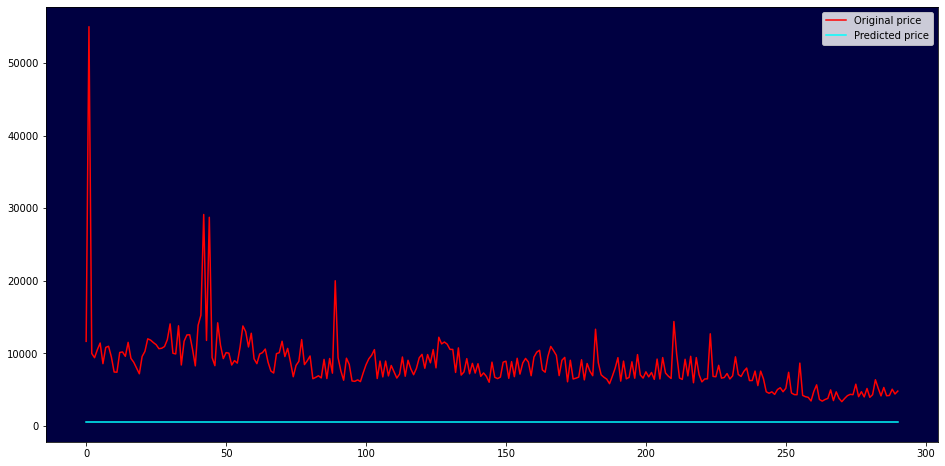

In [207]:
predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)
# y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()

In [208]:
predictions

array([[536.7653 ],
       [536.7653 ],
       [536.76526],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7654 ],
       [536.7653 ],
       [536.76526],
       [536.7653 ],
       [536.76526],
       [536.7654 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.76526],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7654 ],
       [536.7653 ],
       [536.7653 ],
       [536.7654 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],
       [536.7654 ],
       [536.7653 ],
       [536.7653 ],
       [536.7653 ],


## Working on a strategy

In [14]:
# create a new column in the DataFrame to hold positions information
price_df['Position'] = None

# fill our position column based on the following rules:
#     * set to short (-1) when the price hits the upper band
#     * set to long (1) when it hits the lower band       
mode = 'open'
for index in range(len(price_df)):
    if index == 0:
        continue

    row = price_df.iloc[index]
    prev_row = price_df.iloc[index - 1]

    # long?
    if mode == 'open' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = 1
        mode = 'close'

    # short?
    if mode == 'close' and row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
        price_df.iloc[index, price_df.columns.get_loc('Position')] = -1
        mode = 'open'

In [15]:
price_df.dropna(subset=['Position'])


,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position
datetime,,,,,,,,
2014-12-12,350.40,5000.00,314.75,336.24,578.86855,804.255574,353.481526,1
2015-05-31,248.43,927.64,195.76,511.95,326.14610,450.390794,201.901406,-1
2015-09-30,271.56,2617.80,201.41,203.00,303.63670,398.281866,208.991534,1
2015-10-03,248.57,2617.80,191.87,407.83,302.90670,397.546825,208.266575,-1
2018-11-21,6498.87,35999.95,3433.56,4625.66,8346.60400,11162.258646,5530.949354,1


## Visualize position

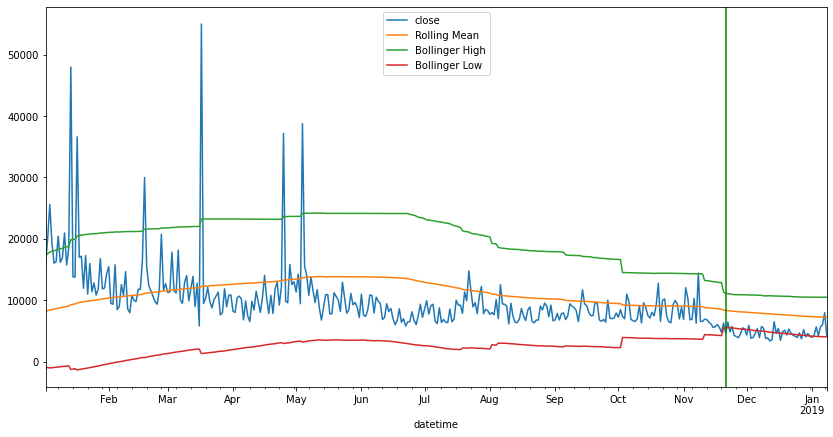

In [16]:

price_df[price_df.index > '2018-01-01'][['close', 'Rolling Mean', 'Bollinger High','Bollinger Low']].plot(figsize=(14, 7))

for index, pos in price_df[price_df.index > '2018-01-01'].dropna(subset=['Position'])['Position'].iteritems():
    plt.axvline(index, color='green' if pos == 1 else 'red')

<AxesSubplot:xlabel='datetime'>

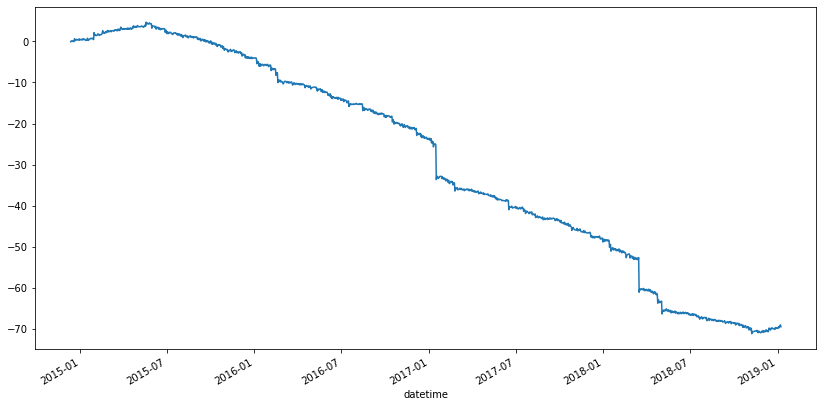

In [102]:
# forward fill our Position column to replace "None" values with the correct buy/sell 
# operations to represent the "holding" of our position forward through time
# price_df.dropna(inplace=True)
price_df['Position'].fillna(method='ffill', inplace=True)

# calculate the daily market return and multiply that by the position to determine strategy returns
price_df['Market Return'] = price_df['close'].pct_change()
price_df['Strategy Return'] = price_df['Market Return'] * price_df['Position']

# plot the strategy returns
price_df['Strategy Return'].cumsum().plot(figsize=(14, 7))

In [18]:
price_df

,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Market Return,Strategy Return
datetime,,,,,,,,,,
2013-09-26,131.95,194.76,98.75,145.11,119.20890,164.312202,74.105598,NaN,NaN,NaN
2013-09-27,148.90,190.11,115.07,129.57,119.49675,164.331286,74.662214,NaN,-0.107091,NaN
2013-09-28,129.81,190.32,101.51,146.22,119.88890,164.471780,75.306020,NaN,0.128502,NaN
2013-09-29,134.18,254.00,114.30,150.18,120.43980,164.316448,76.563152,NaN,0.027082,NaN
2013-09-30,135.19,201.75,118.33,134.82,120.86215,164.123573,77.600727,NaN,-0.102277,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-01-04,4160.00,17765.86,3039.91,4253.74,7299.61170,10505.638173,4093.585227,1.0,-0.250396,-0.250396
2019-01-05,4193.63,49922.62,3103.20,5656.52,7284.80430,10492.448657,4077.159943,1.0,0.329776,0.329776
2019-01-06,5060.00,45000.45,3230.35,6065.13,7283.01505,10491.970786,4074.059314,1.0,0.072237,0.072237


# Finding a better configuration¶


In [19]:
data.head()

,price,volume
datetime,,
2013-03-11 23:57:35,72.00,4.9999
2013-03-12 19:36:32,67.79,1.9999
2013-03-13 12:27:52,52.21,14.7684
2013-03-13 17:06:01,56.29,0.6401
2013-03-13 18:01:20,40.00,1.7500


In [89]:
class BollingerBandsSimulator:

    def __init__(self, df_original, from_date, period, window, no_of_std, figsize=None):
        self.df = df_original
        self.from_date = from_date
        self.period = period
        self.window = window
        self.no_of_std = no_of_std
        self.figsize = figsize
    
    def _build_candles_dataframe(self):
        self.df = self.df.loc[self.from_date:, ["price"]].copy()
        self.df = self.df["price"].resample(self.period).ohlc()
                
    def _build_bollinger_bands(self):
        rolling_mean = self.df['close'].rolling(self.window).mean()
        rolling_std = self.df['close'].rolling(self.window).std()

        self.df['Rolling Mean'] = rolling_mean
        self.df['Bollinger High'] = rolling_mean + (rolling_std * self.no_of_std)
        self.df['Bollinger Low'] = rolling_mean - (rolling_std * self.no_of_std)

    def _calculate_positions(self):
        self.df['Position'] = None
        self.df['Mode'] = None
        self.number_of_trades = 0
        buy_has_crossed_mean = False
        short_has_crossed_mean = False


        mode = 'no_position'
        
        for index in range(len(self.df)):
            if index == 0:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] =  mode
                continue

            row = self.df.iloc[index]
            prev_row = self.df.iloc[index - 1]
            
            # get out of position if price crosses mean
            # (if mode == 'open' or mode == 'no_position' ) and 
            if mode == 'buy'  and row['close'] > row['Rolling Mean']:
                buy_has_crossed_mean = True
                
            if mode == 'short'  and row['close'] < row['Rolling Mean']:
                short_has_crossed_mean = True

            # open -> no_position? no position is below running mean
            if mode == 'buy'  and row['close'] < row['Rolling Mean'] and buy_has_crossed_mean:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 1
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy_to_no_position'
                self.number_of_trades  +=1
                mode = 'no_position'
                buy_has_crossed_mean = False
            
            # close -> no_position? no position if above running mean
            elif mode == 'short'  and row['close'] > row['Rolling Mean'] and short_has_crossed_mean:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = -1
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 0 # for pct change it does a ffilll. ffill with zeros
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short_to_no_position'
                self.number_of_trades  +=1
                mode = 'no_position'
                short_has_crossed_mean = False

            # buy
            elif mode == 'no_position' and row['close'] < row['Bollinger Low'] and prev_row['close'] > prev_row['Bollinger Low']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 # buy. add one to index so that pct_change works
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = 1 # buy. add one to index so that pct_change works
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'buy'
                self.number_of_trades  +=1
                mode = 'buy'     
        
            # short?
            elif mode == 'no_position' and  row['close'] > row['Bollinger High'] and prev_row['close'] < prev_row['Bollinger High']:
                self.df.iloc[index, self.df.columns.get_loc('Position')] = 0 #  short starts at the end of the day. Calculate pct_change starting tomorrow
                self.df.iloc[index + 1, self.df.columns.get_loc('Position')] = -1 #  short starts at the end of the day. Calculate pct_change starting tomorrow
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = 'short'
                self.number_of_trades  +=1
                mode = 'short' 
                       
            else:
                self.df.iloc[index, self.df.columns.get_loc('Mode')] = mode
        
    def _calculate_returns(self):
        
        self.df['Original Position'] = self.df['Position']
        self.df['Position'].fillna(method='ffill', inplace=True)
        self.df['Market Return'] = self.df['close'].pct_change()
        self.df['Strategy Return'] = self.df['Market Return'] * self.df['Position']

    def _plot_returns(self):
        self.df['Strategy Return'].cumsum().plot(figsize=self.figsize)
        

    def simulate(self):
        self._build_candles_dataframe()
        self._build_bollinger_bands()
        self._calculate_positions()
        self._calculate_returns()
        self._plot_returns()

        return (
            self.period, 
            self.window, 
            self.no_of_std, 
            self.df['Strategy Return'].sum(),
            self.number_of_trades
        )

('6H', 90, 1.5, 11.414849028617624, 255)

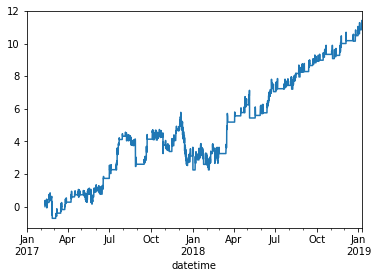

In [104]:

simulator = BollingerBandsSimulator(
    data, 
    from_date="2017-01-01", 
    period="6H", 
    window=90, 
    no_of_std=1.5
)
simulator.simulate()

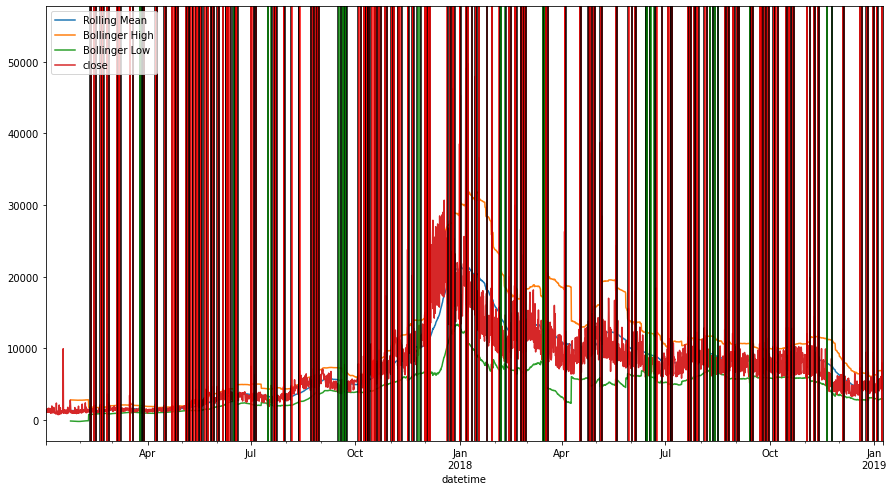

In [100]:
DATE_FILTER = '2017-01-01'
simulator.df[simulator.df.index > DATE_FILTER ]  [['Rolling Mean', 'Bollinger High', 'Bollinger Low', 'close']].plot(figsize=(15,8))

prev_pos = None
for index, pos in simulator.df[simulator.df.index > DATE_FILTER ]['Original Position'].iteritems():
    if pos == -1:
        plt.axvline(index, color='red')
    if pos == 1:
        plt.axvline(index, color='green')
    if pos == 0:
        plt.axvline(index, color='black')


In [101]:
simulator.df[simulator.df.index > "2017-12-25"].head(30)


,open,high,low,close,Rolling Mean,Bollinger High,Bollinger Low,Position,Mode,Original Position,Market Return,Strategy Return
datetime,,,,,,,,,,,,
2017-12-25 06:00:00,22998.39,142744.99,13226.76,15583.99,19993.015556,27433.398577,12552.632534,0.0,no_position,None,-0.323671,-0.000000
2017-12-25 12:00:00,16054.50,55625.60,7348.57,21590.07,20000.516444,27443.779359,12557.253530,0.0,no_position,None,0.385401,0.000000
2017-12-25 18:00:00,20083.95,74999.06,10004.69,20499.99,20049.910444,27466.734194,12633.086695,0.0,no_position,None,-0.050490,-0.000000
2017-12-26 00:00:00,20499.99,75001.88,10190.19,46250.90,20402.000667,28847.187002,11956.814331,0.0,short,0,1.256143,0.000000
2017-12-26 06:00:00,22266.03,62000.12,13176.67,24322.97,20553.033667,28877.273698,12228.793635,-1.0,short,-1,-0.474108,0.474108
2017-12-26 12:00:00,35643.00,75997.08,12618.61,23136.83,20668.510444,28908.032312,12428.988577,-1.0,short,None,-0.048766,0.048766
2017-12-26 18:00:00,16131.86,75789.73,11926.97,25325.11,20737.292111,29005.766872,12468.817350,-1.0,short,None,0.094580,-0.094580
2017-12-27 00:00:00,16320.98,75001.88,12554.09,15899.99,20670.847333,28972.424136,12369.270531,-1.0,short,None,-0.372165,0.372165
2017-12-27 06:00:00,18999.08,77630.11,14754.72,23017.29,20812.117333,28954.135166,12670.099500,-1.0,short_to_no_position,-1,0.447629,-0.447629


In [61]:
simulator.df['Mode'].value_counts()

no_position           683
buy                    54
buy_to_no_position      1
Name: Mode, dtype: int64

# Brute force some configurations¶


In [19]:
 # generate a linear space of value values for each parameter in the configuration
# a take some random samples from them.
# for example the first one creates a vector of 5 evenly spaced integer values ranging from 10 to 100
windows = np.linspace(7, 90, 8, dtype=int)
stds = np.linspace(1.5, 2, 2)
periods = np.linspace(15 ,240, 6, dtype=int)

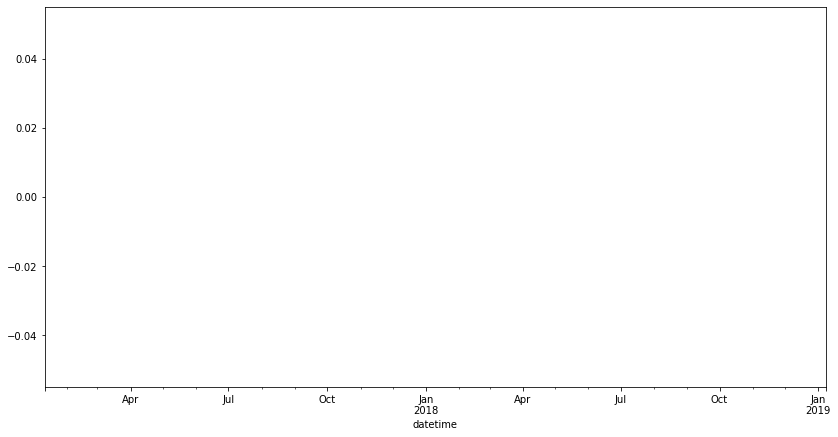

In [20]:
# iterate through them, running the strategy function each time and collecting returns
# (this might take some time)
simulations = []
result_df = pd.DataFrame({
    'period': [], 
    'window': [],
    'no_of_std': [],
    'result': []
})
for window in windows:
    for std in stds:
        for period in periods:
            simulator = BollingerBandsSimulator(
                data, 
                from_date="2017-01-11", 
                period="{}min".format(period), 
                window=window, 
                no_of_std=std,
                figsize=(14, 7)
            )
            period, window, no_of_std, result, total_trades = simulator.simulate()
            result_df = result_df.append({
                'period': period, 
                'window': window, 
                'no_of_std': no_of_std, 
                'result': result,
                'total_trades': total_trades
            }, ignore_index=True)
            simulations.append(simulator)

In [23]:
result_df.sort_values(by='result').tail(15) # Hours results in 1-2 trades. Test minutes

,period,window,no_of_std,result,total_trades
37,60min,42.0,1.5,0.0,0.0
36,15min,42.0,1.5,0.0,0.0
35,240min,30.0,2.0,0.0,0.0
34,195min,30.0,2.0,0.0,0.0
33,150min,30.0,2.0,0.0,0.0
32,105min,30.0,2.0,0.0,0.0
31,60min,30.0,2.0,0.0,0.0
30,15min,30.0,2.0,0.0,0.0
29,240min,30.0,1.5,0.0,0.0
28,195min,30.0,1.5,0.0,0.0


In [22]:
result_df.sort_values(by='result').tail(15).mean()

/var/folders/0r/jkhwtgvx0wb9vrk6xn4bmz2m0000gn/T/ipykernel_85509/3784085997.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result_df.sort_values(by='result').tail(15).mean()


window          39.600000
no_of_std        1.766667
result           0.000000
total_trades     0.000000
dtype: float64

In [ ]:
WINNING_STRATEGY_INDEX = 30

### Look at the trading pattern for a winning strategy

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum()

datetime
2018-01-11 00:00:00         NaN
2018-01-11 06:40:00         NaN
2018-01-11 13:20:00         NaN
2018-01-11 20:00:00         NaN
2018-01-12 02:40:00         NaN
                         ...   
2019-01-07 02:40:00    2.798846
2019-01-07 09:20:00    3.080088
2019-01-07 16:00:00    3.041177
2019-01-07 22:40:00    3.071222
2019-01-08 05:20:00    3.091579
Freq: 400T, Name: Strategy Return, Length: 1305, dtype: float64

<AxesSubplot:xlabel='datetime'>

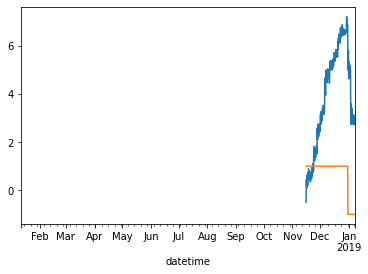

In [ ]:
simulations[WINNING_STRATEGY_INDEX].df['Strategy Return'].cumsum().plot()
simulations[WINNING_STRATEGY_INDEX].df['Position'].plot()

<AxesSubplot:xlabel='datetime'>

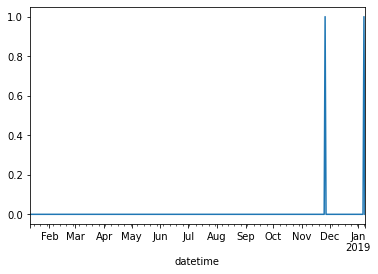

In [162]:
simulations[WINNING_STRATEGY_INDEX].df['Number of Trades'].plot()